# <center> ПРАКТИКА. СТАТИСТИЧЕСКИЕ ТЕСТЫ В EDA.
## ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

## Постановка задачи
HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

Необходимо выяснить, какие факторы влияют на зарплату специалиста Data Scientist.

А также ответить на ключевые вопросы HR-агентства:
1) Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
2) Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
3) Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
4) Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?


Описание столбцов:
- work_year	Год, в котором была выплачена зарплата.
- experience_level	Опыт работы на этой должности в течение года со следующими возможными значениями:
    - EN — Entry-level/Junior;
    - MI — Mid-level/Intermediate;
    - SE — Senior-level/Expert;
    - EX — Executive-level/Director.
- employment_type	Тип трудоустройства для этой роли:
    - PT — неполный рабочий день;
    - FT — полный рабочий день;
    - CT — контракт;
    - FL — фриланс.
- job_title	Роль, в которой соискатель работал в течение года.
- salary	Общая выплаченная валовая сумма заработной платы.
- salary_currency	Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
- salary_in_usd	Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
- employee_residence	Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
- remote_ratio	Общий объём работы, выполняемой удалённо. Возможные значения:
    - 0 — удалённой работы нет (менее 20 %);
    - 50 — частично удалённая работа;
    - 100 — полностью удалённая работа (более 80 %).
- company_location	Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
- company_size	Среднее количество людей, работавших в компании в течение года:
    - S — менее 50 сотрудников (небольшая компания);
    - M — от 50 до 250 сотрудников (средняя компания);
    - L — более 250 сотрудников (крупная компания).

## Загрузка данных

In [2]:
#загружаем необходмые для работы библиотеки
import pandas as pd
import numpy as np

#для статистических тестов
from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

#для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [3]:
#загружаем датасет
data = pd.read_csv('ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [4]:
#назначаем уровень значимости
alpha = 0.05
print("Уровень значимости равен = {:.2f}".format(alpha))

Уровень значимости равен = 0.05


## Описательный анализ данных

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


In [6]:
data.describe()

,Unnamed: 0,work_year,salary,salary_in_usd,remote_ratio
count,607.000000,607.000000,6.070000e+02,607.000000,607.00000
mean,303.000000,2021.405272,3.240001e+05,112297.869852,70.92257
std,175.370085,0.692133,1.544357e+06,70957.259411,40.70913
min,0.000000,2020.000000,4.000000e+03,2859.000000,0.00000
25%,151.500000,2021.000000,7.000000e+04,62726.000000,50.00000
50%,303.000000,2022.000000,1.150000e+05,101570.000000,100.00000
75%,454.500000,2022.000000,1.650000e+05,150000.000000,100.00000
max,606.000000,2022.000000,3.040000e+07,600000.000000,100.00000


<Axes: >

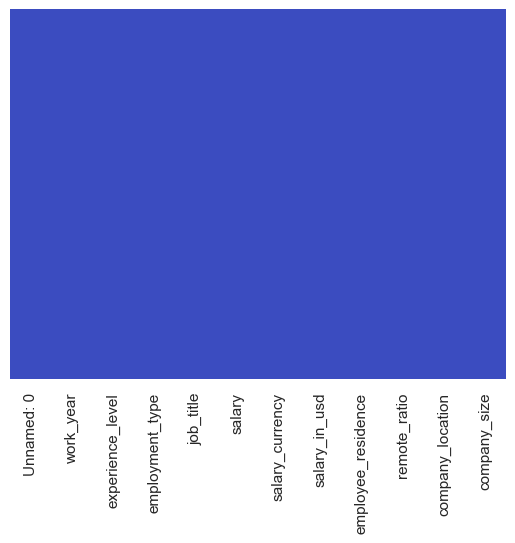

In [7]:
#визуализация отсутствующих значений
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='coolwarm')

В датасете 607 записей, пропущенных значений нет.


Проверим данные на наличие дубликатов:

In [8]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

Количество дубликатов: 0


In [9]:
data.isnull().mean()

Unnamed: 0            0.0
work_year             0.0
experience_level      0.0
employment_type       0.0
job_title             0.0
salary                0.0
salary_currency       0.0
salary_in_usd         0.0
employee_residence    0.0
remote_ratio          0.0
company_location      0.0
company_size          0.0
dtype: float64

In [10]:
print(data.shape)
print(data.dtypes)


(607, 12)
Unnamed: 0             int64
work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object


In [11]:
#удаляем колонку unnamed
data.drop('Unnamed: 0', axis = 1, inplace = True)
data

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


In [12]:
data.corr(numeric_only = True)

,work_year,salary,salary_in_usd,remote_ratio
work_year,1.000000,-0.087577,0.170493,0.076314
salary,-0.087577,1.000000,-0.083906,-0.014608
salary_in_usd,0.170493,-0.083906,1.000000,0.132122
remote_ratio,0.076314,-0.014608,0.132122,1.000000


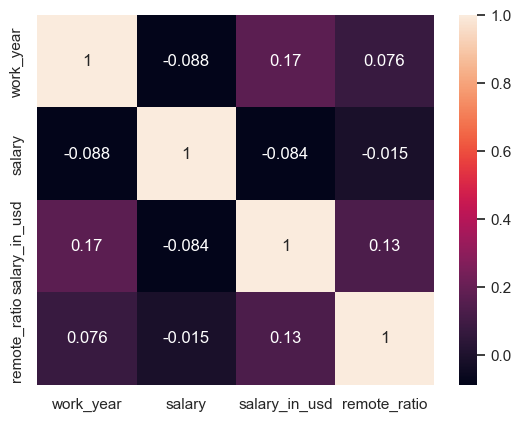

In [13]:
sns.heatmap(data.corr(numeric_only=True), annot=True)
figsize=(10,10)

Сильной корреляции между признаками не выявлено.

Разделим признаки на числовые и категориальные:

In [14]:
# отбор числовых колонок
data_numeric = data.select_dtypes(include=[np.number])
numeric_cols = data_numeric.columns.values
print(numeric_cols)

['work_year' 'salary' 'salary_in_usd' 'remote_ratio']


In [15]:
# отбор нечисловых колонок
data_non_numeric = data.select_dtypes(exclude=[np.number])
non_numeric_cols = data_non_numeric.columns.values
print(non_numeric_cols)

['experience_level' 'employment_type' 'job_title' 'salary_currency'
 'employee_residence' 'company_location' 'company_size']


### Поиск выбросов

<Axes: >

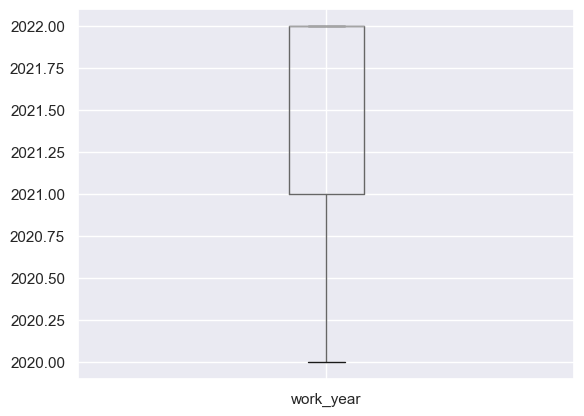

In [16]:
data.boxplot(column=['work_year'])

выбросов нет

<Axes: >

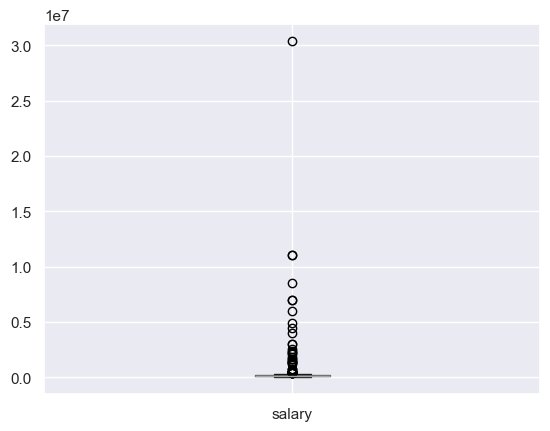

In [17]:
data.boxplot(column=['salary'])

выброс есть

<Axes: >

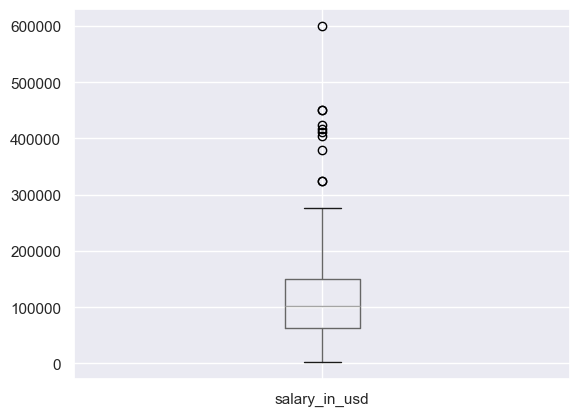

In [18]:
data.boxplot(column=['salary_in_usd'])

выброс есть

<Axes: >

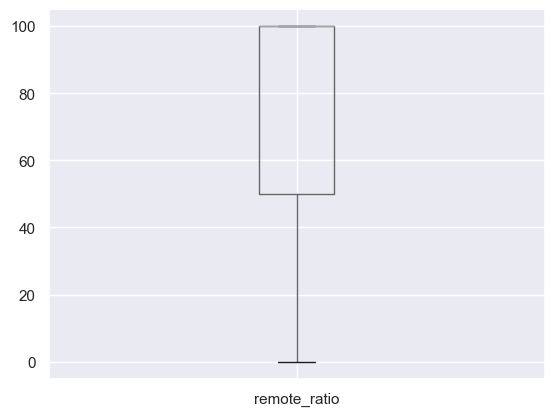

In [19]:
data.boxplot(column=['remote_ratio'])

выбросов нет

Имеем признаки:

категориальные:
- experience_level  
- employment_type 
- remote_ratio 
- company_size  
- company_location 
- salary_currency 
- employee_residence 
- job_title 

числовые:
- work_year
- salary
- salary_in_usd

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

Text(0.5, 1.0, 'Распределение зарплаты')

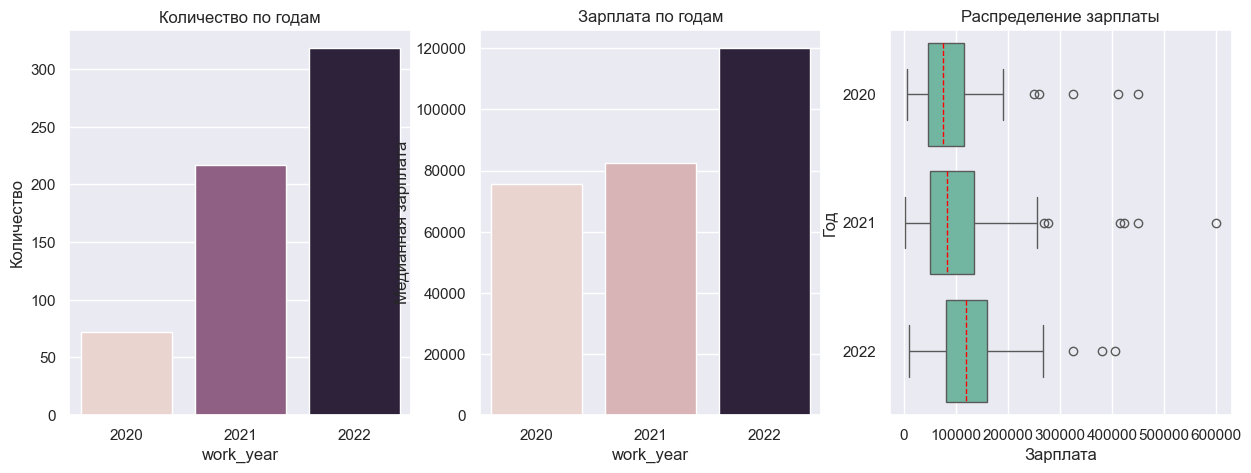

In [20]:
data_sal = data.groupby( ['work_year'], observed=False )['salary_in_usd'].count().to_frame()
data_sal.columns = ['Количество']

data_median = data.groupby( ['work_year'], observed=False )['salary_in_usd'].median().round(0).to_frame()
data_median.columns = ['Медианная зарплата']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(data_sal, x='work_year',y='Количество', hue='Количество', ax=axes[0], legend=False)
axes[0].set_title("Количество по годам")

sns.barplot(data_median, x='work_year',y='Медианная зарплата', hue='Медианная зарплата', ax=axes[1], legend=False)
axes[1].set_title("Зарплата по годам")

sns.boxplot(data, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[2])
axes[2].set( ylabel="Год", xlabel="Зарплата")
axes[2].set_title('Распределение зарплаты')

Выводы:
1. рост зарплаты по годам, особенно большой прирост в 2022 г
2. Медаиана зарплат по годам отличается
3. Зарплаты в 2020 и 2021 гг примерно равны

### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

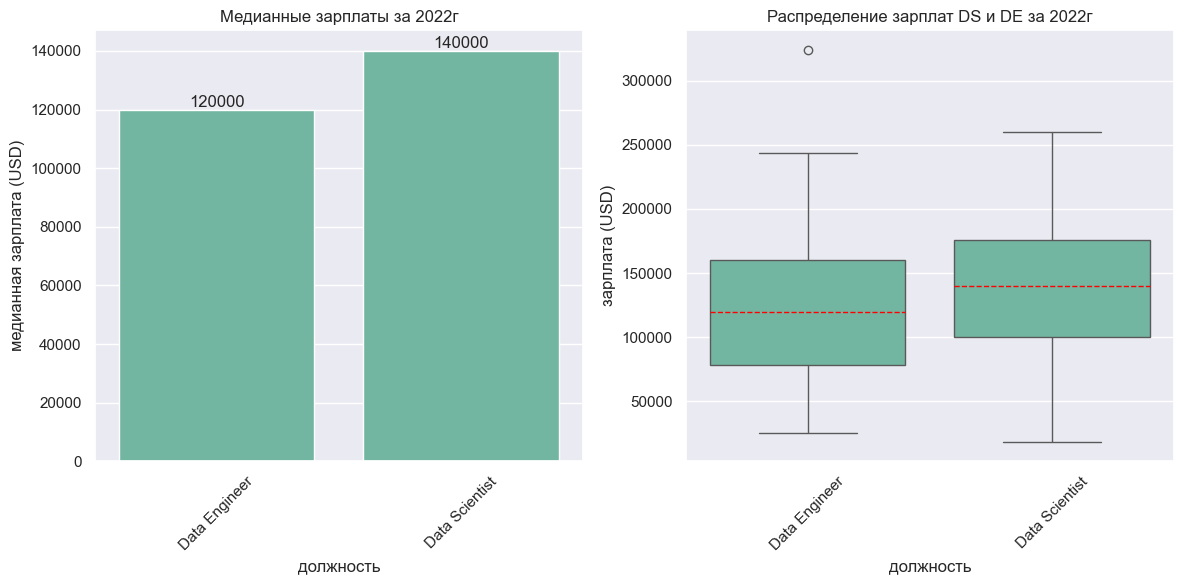

In [21]:
# Фильтруем данные за 2022 год для Data Scientist и Data Engineer
year22_ds_de = data[(data['work_year'] == 2022) & 
                    (data['job_title'].isin(['Data Scientist', 'Data Engineer']))].copy()

# Вычисляем медианные зарплаты для этих профессий за 2022 год
medians_2022 = year22_ds_de.groupby('job_title')['salary_in_usd'].median().reset_index()
medians_2022.columns = ['job_title', 'медианная зарплата']

# Графики
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# Первый график - барплот с медианными зарплатами
sns.barplot(data=medians_2022, x='job_title', y='медианная зарплата', ax=axes[0])
axes[0].set_xlabel("должность")
axes[0].set_ylabel("медианная зарплата (USD)")
axes[0].set_title('Медианные зарплаты за 2022г')

# Второй график - боксплот с распределением зарплат
sns.boxplot(data=year22_ds_de, x='job_title', y='salary_in_usd', 
           medianprops={"color": "red", "linestyle": '--'}, ax=axes[1])
axes[1].set_xlabel("должность")
axes[1].set_ylabel("зарплата (USD)")
axes[1].set_title('Распределение зарплат DS и DE за 2022г')

# Поворачиваем подписи на оси X для лучшей читаемости
for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    
#добавляем числовые значения
for container in axes[0].containers:
    axes[0].bar_label(container)

plt.tight_layout()
plt.show()

Вывод: медианная заработная плата Дата саентиста выше чем заработная плата Дата инженера за 2022г

### Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

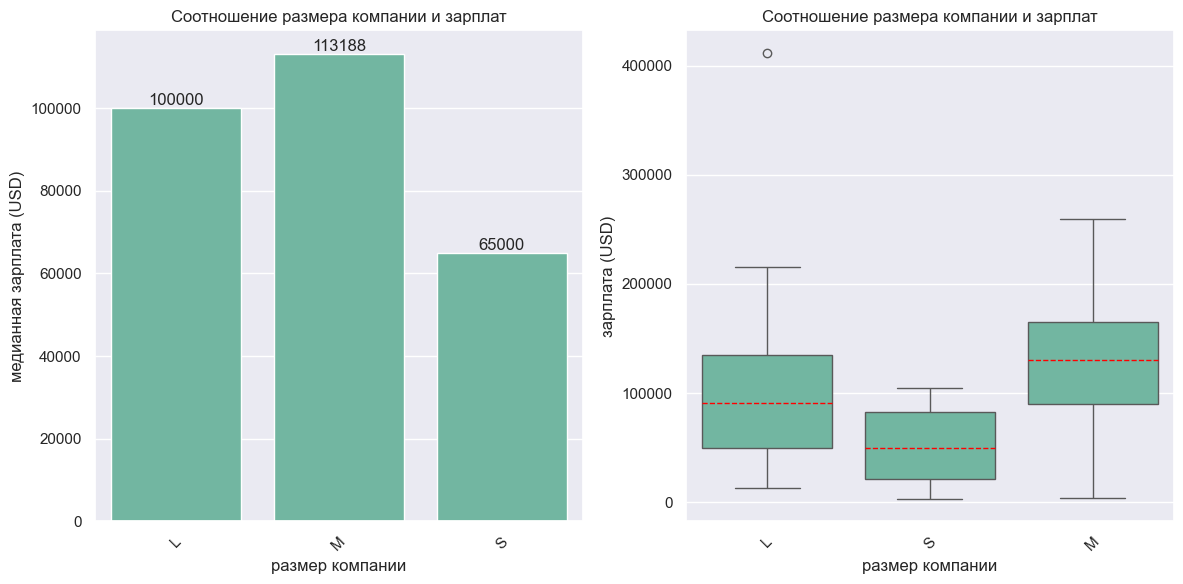

In [22]:
#создаем датасеты
data_median = data.groupby( ['company_size'], observed=False )['salary_in_usd'].median().round(0).to_frame()
data_median.columns = ['Медианная зарплата']
data_ds = data[(data['job_title'] == 'Data Scientist')].copy()

#построение графиков
ig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

#первый график с распределение медианной зарплаты и размера компании
sns.barplot(data=data_median, x='company_size', y='Медианная зарплата', ax=axes[0])
axes[0].set_xlabel("размер компании")
axes[0].set_ylabel("медианная зарплата (USD)")
axes[0].set_title('Соотношение размера компании и зарплат')

# Второй график - боксплот с распределением зарплат
sns.boxplot(data=data_ds, x='company_size', y='salary_in_usd', 
           medianprops={"color": "red", "linestyle": '--'}, ax=axes[1])
axes[1].set_xlabel("размер компании")
axes[1].set_ylabel("зарплата (USD)")
axes[1].set_title('Соотношение размера компании и зарплат')

# Поворачиваем подписи на оси X для лучшей читаемости
for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    
#добавляем числовые значения
for container in axes[0].containers:
    axes[0].bar_label(container)

plt.tight_layout()
plt.show()


Вывод: медианные зарплаты в компаниях разного размера отличаются, причем распределение **незакономерно!** наибольшая медианная заробтная плата в компании среднего размера, далее по убыванию в компании крупного размера и далее в маленькой компании.

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

In [23]:
#строим таблицу сопряженности
cross_tab = pd.crosstab(index=data['company_size'], columns=data['job_title'])
cross_tab

job_title,3D Computer Vision Researcher,AI Scientist,Analytics Engineer,Applied Data Scientist,Applied Machine Learning Scientist,BI Data Analyst,Big Data Architect,Big Data Engineer,Business Data Analyst,Cloud Data Engineer,...,Machine Learning Manager,Machine Learning Scientist,Marketing Data Analyst,NLP Engineer,Principal Data Analyst,Principal Data Engineer,Principal Data Scientist,Product Data Analyst,Research Scientist,Staff Data Scientist
company_size,,,,,,,,,,,,,,,,,,,,,
L,0,2,0,5,2,2,0,4,4,1,...,1,4,1,1,0,2,3,1,11,0
M,1,2,4,0,2,2,1,2,1,0,...,0,2,0,0,1,1,3,0,3,1
S,0,3,0,0,0,2,0,2,0,1,...,0,2,0,0,1,0,1,1,2,0


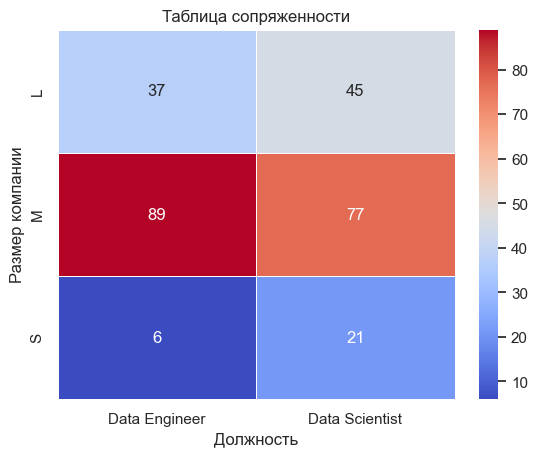

In [24]:
#создаем датасет для DS и DE
ds_de = data[(data['job_title'].isin(['Data Scientist', 'Data Engineer']))].copy()
# Подготовка сводной таблицы
cross_tab = pd.crosstab(index=ds_de['company_size'], columns=data['job_title'])
# Создаем тепловую карту
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Должность', ylabel='Размер компании')
plt.title('Таблица сопряженности')
plt.show()

Связь между наличием должностей Data Scientist и Data Engineer  и размером компании имеется

### КАКИЕ ФАКТОРЫ ВЛИЯЮТ НА ЗАРПЛАТУ DATA SCIENTIST?

### Статистические тесты

### 1. Зарплата Data Scientist зависит от года?

*Нулевая гипотеза*: Зарплата Data Scientist не зависит от года

*Альтернативная гипотеза*: Зарплата Data Scientist зависит от года

In [25]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

In [26]:
#получим данные по зарплатам за 2020,2021,2022 года

salary_2020 = data_ds.loc[data_ds['work_year']==2020, 'salary_in_usd'].copy()
salary_2021 = data_ds.loc[data_ds['work_year']==2021, 'salary_in_usd'].copy()
salary_2022 = data_ds.loc[data_ds['work_year']==2022, 'salary_in_usd'].copy()

#проводим тест Шапиро-Уилка
print('2020:')
result = stats.shapiro(salary_2020)
decision_normality(result[1])

print('2021:')
result = stats.shapiro(salary_2021)
decision_normality(result[1])

print('2022:')
result = stats.shapiro(salary_2022)
decision_normality(result[1])

2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
2021:
p-value = 0.125
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
2022:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


Выбираем статистический тест:
* Какой тип у признака? — Количественный.
* Сколько сравниваемых групп? — 3.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

*Соответственно, мы должны использовать тест Краскела-Уоллиса*

In [27]:
_, p = stats.kruskal(salary_2022, salary_2021, salary_2022)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**ВЫВОД: заработные платы Data Scientist отличаются по годам**

### 2. На зарплату Data Scientist влияет размер компании?

*Нулевая гипотеза* : не влияет размер компании на зарплату

*Альтернативная гипотеза* : размер компании влияет на зарплату

In [30]:
# собираем значения зарплат и размеры компании
salary_s = data_ds.loc[data_ds['company_size']=='S', 'salary_in_usd']
salary_m = data_ds.loc[data_ds['company_size']=='M', 'salary_in_usd']
salary_l = data_ds.loc[data_ds['company_size']=='L', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Небольшая компания:')
result = stats.shapiro(salary_s)
decision_normality(result[1])

print('Средняя компания:')
result = stats.shapiro(salary_m)
decision_normality(result[1])

print('Крупная компания:')
result = stats.shapiro(salary_l)
decision_normality(result[1])


Небольшая компания:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Средняя компания:
p-value = 0.639
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Крупная компания:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Выбираем статистический тест:
* Какой тип у признака? — Количественный.
* Сколько сравниваемых групп? — 3.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

*Соответственно, мы должны использовать тест Краскела-Уоллиса*

In [31]:
_, p = stats.kruskal(salary_s, salary_m, salary_l)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод: размер компании влияет на заработную плату Data Scientist**

### 3. Зарплата Data Scientist в компании среднего размера и крупной компании различны

*Нулевая гипотеза* : не отличается

*Альтернативная гипотеза* : отличается

In [34]:
print('Средняя компания:')
result = stats.shapiro(salary_m)
decision_normality(result[1])

print('Крупная компания:')
result = stats.shapiro(salary_l)
decision_normality(result[1])

Средняя компания:
p-value = 0.639
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Крупная компания:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Выбираем статистический тест:
* Какой тип у признака? — Количественный.
* Сколько сравниваемых групп? — 2.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

*Соответственно, мы должны использовать U-критерий Манна-Уитни*

In [36]:
# проводим тест
_, p = stats.mannwhitneyu(salary_m, salary_l, alternative='two-sided')
decision_hypothesis(p)

p-value = 0.011
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод: заработные платы в средней и крупной компаниях отличаются**

### 4. Зарплата(медианная) Data Scientist в компании среднего размера больше 50 000 долларов?

*Нулевая гипотеза* : медианная зарплата в компании среднего размера меньше или равна 50 тыс долларов

*Альтернативная гипотеза* : медианная зарплата в компании среднего размера больше 50 тыс долларов

In [37]:
# проводим тест Шапиро-Уилка
print('Для компании среднего размера:')
result = stats.shapiro(salary_s)
decision_normality(result[1])

Для компании среднего размера:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


Выбираем статистический тест:
* Какой тип у признака? — Количественный.
* Сколько сравниваемых групп? — 1.
* Признак распределён по нормальному закону? — Да. 

*Соответственно, мы должны использовать Одновыборочный t-критерий*

In [39]:
# проводим тест
_, p = stats.ttest_1samp(salary_s, popmean=500000, alternative='greater')
decision_hypothesis(p)

p-value = 1.000
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод: медианная заработная плата в компании среднего размера больше чем 50 000 долларов**

### 5. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

*Нулевая гипотеза* : связи нет - признаки независимы

*Альтернативная гипотеза* : связь есть - признаки зависимы

Выбираем статистический тест:
* Какой тип у признаков? — Категориальный.
* Сколько сравниваемых групп? — 2.
* Группы зависимы? — Нет.

*Соответственно, мы должны использовать ${\chi}^2$ (хи-квадрат)*

In [41]:
cross_table = pd.crosstab(ds_de['job_title'], ds_de['company_size'])
cross_table

company_size,L,M,S
job_title,,,
Data Engineer,37,89,6
Data Scientist,45,77,21


In [42]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.008
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод: связь между наличием должностей Data Scientist и Data Engineer и размером компании есть**

### 6.Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

*Нулевая гипотеза* : зарплата DS  меньше или равна чем DE в 2022 году

*Альтернативная гипотеза* : зарплата DS больше чем DE в 2022 году

In [45]:
#создаем датасет для Data Engineer
data_de = data[(data['job_title'] == 'Data Engineer')].copy()
#собираем данные
salary_ds_22 = data_ds.loc[ds_de['work_year']==2022, 'salary_in_usd'].copy()
salary_de_22 = data_de.loc[ds_de['work_year']==2022, 'salary_in_usd'].copy()

# проводим тест Шапиро-Уилка
print('Для 2022, Data Science:')
result = stats.shapiro(salary_ds_22)
decision_normality(result[1])

print('Для 2022, Data Engeneer:')
result = stats.shapiro(salary_de_22)
decision_normality(result[1])

Для 2022, Data Science:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2022, Data Engeneer:
p-value = 0.010
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Выбираем статистический тест:
* Какой тип у признака? — Количественный.
* Сколько сравниваемых групп? — 2.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

*Соответственно, мы должны использовать U-критерий Манна-Уитни*

In [49]:
# проводим тест
_, p = stats.mannwhitneyu(salary_ds_22, salary_de_22, alternative='greater')
decision_hypothesis(p)

p-value = 0.077
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод: зарплата Data Scientist меньше или равна зарплате Data Engineer в 2022 году**

## Итоговые результаты исследования по данным о зарплатах в сфере Data Science за 2020–2022 годы 

* наблюдается рост заработной платы по годам, особенно за 2022 год
* заработные платы в 2021 году и 2020 году примерно равны
* в среднем заработная плата Дата саентиста выше заработной платы Дата инженера за 2022 г
* медианные заработные платы в компаниях разного размера отличаются, причем *незакономерно!* наибольшая зарплата в компании среднего размера, наименьшая в компании малого размера
* размер компании влияет на размер заплаты дата саентиста
* медианная зарплата Дата саентиста в компании среднего размера больше 50 000 долларов